In [1]:
import numpy as np
import gs
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Let us load the MNIST dataset first.

In [3]:
(x_train, y_train), (_, _) = mnist.load_data()

# And extract some images belonging to some class, say 1.
x_1 = x_train[np.where(y_train == 1)]
# Reshape it into 2d array
x_1 = np.reshape(x_1, (-1, 784))
# Finally, compute RLT
rlts = gs.rlts(x_1, gamma=1.0/128, n=10) # Take all data in class 1
mrlt = np.mean(rlts, axis=0)

In [16]:
mrlt.shape

(100,)

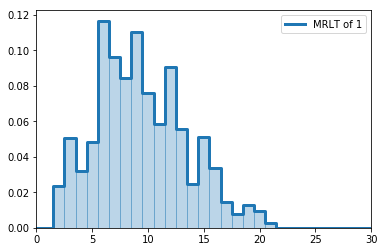

In [15]:
gs.fancy_plot(mrlt, label='MRLT of 1')
plt.xlim([0, 30])
plt.legend()

In [ ]:
real_manifold
fake_manifold
compute_geometry_score(real_manifold, fake_manifold)

In [17]:
import torch
import torch.nn
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data


mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
mb_size = 32
z_dim = 128
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128
cnt = 0
lr = 1e-4
lam1 = 1e-2
lam2 = 1e-2


def log(x):
    return torch.log(x + 1e-8)


E = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, z_dim)
)

G = torch.nn.Sequential(
    torch.nn.Linear(z_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, X_dim),
    torch.nn.Sigmoid()
)

D = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, 1),
    torch.nn.Sigmoid()
)


def reset_grad():
    G.zero_grad()
    D.zero_grad()
    E.zero_grad()


def sample_X(size, include_y=False):
    X, y = mnist.train.next_batch(size)
    X = Variable(torch.from_numpy(X))

    if include_y:
        y = np.argmax(y, axis=1).astype(np.int)
        y = Variable(torch.from_numpy(y))
        return X, y

    return X


E_solver = optim.Adam(E.parameters(), lr=lr)
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)



for it in range(1000000):
    """ Discriminator """
    # Sample data
    X = sample_X(mb_size)
    z = Variable(torch.randn(mb_size, z_dim))

    # Dicriminator_1 forward-loss-backward-update
    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)

    D_loss = -torch.mean(log(D_real) + log(1 - D_fake))

    D_loss.backward()
    D_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    """ Generator """
    # Sample data
    X = sample_X(mb_size)
    z = Variable(torch.randn(mb_size, z_dim))

    # Generator forward-loss-backward-update
    G_sample = G(z)
    G_sample_reg = G(E(X))
    D_fake = D(G_sample)
    D_reg = D(G_sample_reg)

    geometry_score_G = torch.sum((X - G_sample_reg)**2, 1)
    reg = torch.mean(lam1 * geometry_score_G + lam2 * log(D_reg))
    G_loss = -torch.mean(log(D_fake)) + reg

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    """ Encoder """
    # Sample data
    X = sample_X(mb_size)
    z = Variable(torch.randn(mb_size, z_dim))

    G_sample_reg = G(E(X))
    D_reg = D(G_sample_reg)

    geometry_score_E = torch.sum((X - G_sample_reg)**2, 1)
    E_loss = torch.mean(lam1 * geometry_score_E + lam2 * log(D_reg))

    E_loss.backward()
    E_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; E_loss: {}; G_loss: {}'
              .format(it, D_loss.data.numpy(), E_loss.data.numpy(), G_loss.data.numpy()))

        samples = G(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'
                    .format(str(cnt).zfill(3)), bbox_inches='tight')
        cnt += 1
        plt.close(fig)

ModuleNotFoundError: No module named 'torch'